# 4. Quantum gradients with backpropagation

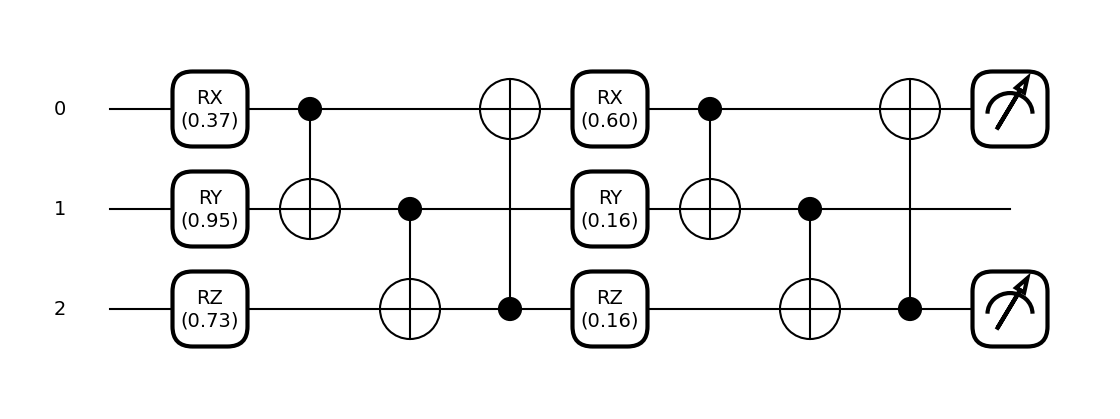

In [5]:
fig, ax = qml.draw_mpl(circuit, decimals = 2)(params)
plt.show()

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

dev = qml.device("default.qubit", wires = 3)

@qml.qnode(dev, diff_method = "parameter-shift")
def circuit(params):
    qml.RX(params[0], wires = 0)
    qml.RY(params[1], wires = 1)
    qml.RZ(params[2], wires = 2)
    
    qml.broadcast(qml.CNOT, wires = [0, 1, 2], pattern = "ring")
    
    qml.RX(params[3], wires = 0)
    qml.RY(params[4], wires = 1)
    qml.RZ(params[5], wires = 2)
    
    qml.broadcast(qml.CNOT, wires = [0, 1, 2], pattern = "ring")
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

In [4]:
params = np.random.random([6], requires_grad = True)

print("Parameters:", params)
print("Expectation value:", circuit(params))

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation value: -0.11971365706871567


In [6]:
def parameter_shift_term(qnode, params, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted)
    
    shifted[i] -= np.pi
    backward = qnode(shifted)
    
    return 0.5 * (forward - backward)

print(parameter_shift_term(circuit, params, 0))

-0.06518877224958124


In [7]:
def parameter_shift(qnode, params):
    gradients = np.zeros([len(params)])
    
    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode, params, i)
        
    return gradients

print(parameter_shift(circuit, params))

[-6.51887722e-02 -2.72891905e-02 -1.38777878e-17 -9.33934621e-02
 -7.61067572e-01  0.00000000e+00]


## Benchmarking for parameter shift method

In [8]:
dev = qml.device("default.qubit", wires = 4)

@qml.qnode(dev, diff_method = "parameter-shift")
def circuit(params):
    qml.StronglyEntanglingLayers(params, wires = [0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

param_shape = qml.StronglyEntanglingLayers.shape(n_wires = 4, n_layers = 15)
params = np.random.normal(scale = 0.1, size = param_shape, requires_grad = True)
print(params.size)
print(circuit(params))

180
0.8947771876917631


In [9]:
import timeit

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals = globals(), number = num, repeat = reps)
forward_time = min(times) / num

print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.011210739999999931 sec per loop


In [10]:
grad_fn = qml.grad(circuit)

times = timeit.repeat("grad_fn(params)", globals = globals(), number = num, repeat = reps)
backward_time = min(times) / num

print(f"Gradient computation (best of {reps}): {backward_time} sec per loop")

Gradient computation (best of 3): 5.07956817 sec per loop


## Benchmarking for bacpropagation method

In [11]:
dev = qml.device("default.qubit", wires = 4)

@qml.qnode(dev, diff_method = "backprop")
def circuit(params):
    qml.StronglyEntanglingLayers(params, wires = [0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

param_shape = qml.StronglyEntanglingLayers.shape(n_wires = 4, n_layers = 15)
params = np.random.normal(scale = 0.1, size = param_shape, requires_grad = True)
print(circuit(params))

0.9358535378025427


In [12]:
import timeit
reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals = globals(), number = num, repeat = reps)
forward_time = min(times) / num
print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.0366478399999778 sec per loop


In [13]:
times = timeit.repeat("qml.grad(circuit)(params)", globals = globals(), number = num, repeat = reps)
backward_time = min(times) / num
print(f"Backward pass (best of {reps}): {backward_time} sec per loop")

Backward pass (best of 3): 0.10355863999998291 sec per loop


## Time comparison between the two methods

In [15]:
dev = qml.device("default.qubit", wires = 4)

def circuit(params):
    qml.StronglyEntanglingLayers(params, wires = [0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

In [30]:
reps, num = 2, 3

forward_shift, gradient_shift, forward_backprop, gradient_backprop = [], [], [], []

for depth in range(0, 21):
    param_shape = qml.StronglyEntanglingLayers.shape(n_wires = 4, n_layers = depth)
    params = np.random.normal(scale = 0.1, size = param_shape, requires_grad = True)
    num_params = params.size
    
    #forward pass timing
    qnode_shift = qml.QNode(circuit, dev, diff_method = "parameter-shift")
    qnode_backprop = qml.QNode(circuit, dev, diff_method = "backprop")
    
    t = timeit.repeat("qnode_shift(params)", globals = globals(), number = num, repeat = reps)
    forward_shift.append([num_params, min(t) / num])
    
    t = timeit.repeat("qnode_backprop(params)", globals = globals(), number = num, repeat = reps)
    forward_backprop.append([num_params, min(t) / num])
    
    if num_params == 0:
        continue
        
    #gradient timing
    qnode_shift = qml.QNode(circuit, dev, diff_method = "parameter-shift")
    qnode_backprop = qml.QNode(circuit, dev, diff_method="backprop")
    
    t = timeit.repeat("qml.grad(qnode_shift)(params)", globals=globals(), number=num, repeat=reps)
    gradient_shift.append([num_params, min(t) / num])
    
    t = timeit.repeat("qml.grad(qnode_backprop)(params)", globals=globals(), number=num, repeat=reps)
    gradient_backprop.append([num_params, min(t) / num])
    
gradient_shift = np.array(gradient_shift).T
gradient_backprop = np.array(gradient_backprop).T
forward_shift = np.array(forward_shift).T
forward_backprop = np.array(forward_backprop).T

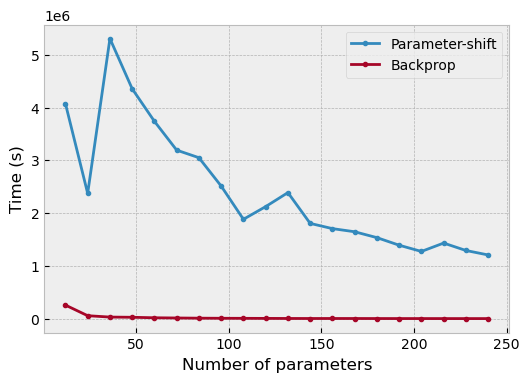

In [29]:
plt.style.use("bmh")
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

ax.plot(*gradient_shift, '.-', label = "Parameter-shift")
ax.plot(*gradient_backprop, '.-', label = "Backprop")
ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of parameters")
ax.legend()

plt.show()

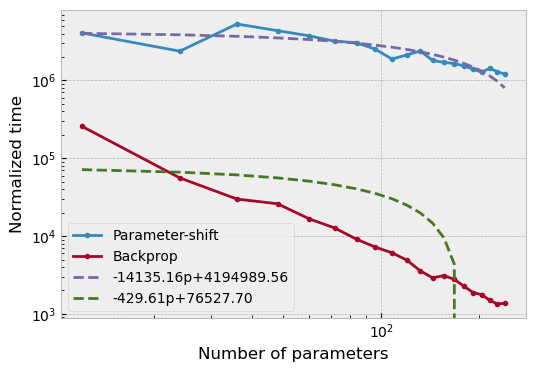

In [28]:
gradient_shift[1] /= forward_shift[1, 1:]
gradient_backprop[1] /= forward_backprop[1, 1:]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

ax.plot(*gradient_shift, '.-', label = "Parameter-shift")
ax.plot(*gradient_backprop, '.-', label = "Backprop")

x = gradient_shift[0]
m_shift, c_shift = np.polyfit(*gradient_shift, deg = 1)
m_back, c_back = np.polyfit(*gradient_backprop, deg = 1)

ax.plot(x, m_shift * x + c_shift, '--', label = f"{m_shift:.2f}p{c_shift:+.2f}")
ax.plot(x, m_back * x + c_back, '--', label = f"{m_back:.2f}p{c_back:+.2f}")

ax.set_ylabel("Normalized time")
ax.set_xlabel("Number of parameters")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.show()